# Problem set 11: Word embeddings and sentiment

## Summary and general instructions

**Predict the polarity of album reviews from *Pitchfork*, 1999-2017, using token features and word embeddings.**

This week, we're back to classification, though the problem might easily be transformed into a regression task. We'll examine a [corpus of more than 18,000 album reviews published between 1999 and 2017 on the music site *Pitchfork*](https://www.kaggle.com/nolanbconaway/pitchfork-data/data). Our dataset includes the full text of each review, along with a numerical rating of the album in question (between 0 and 10). We'll classify a review as positive if its score is above the corpus mean and negative if the score is below the corpus mean.

## Imports and setup

Recall that you can install SpaCy, if you haven't done so already, by running the following two lines in a code cell:

```
!conda install -c conda-forge spacy spacy-lookups-data -y
!python -m spacy download en_core_web_lg
```

Note that we've here installed the ***large* spaCy model**, which contains 300-dimensional word embeddings. Be sure to install this model if you haven't done so already (we used it in class, but not in the previous problem set).

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from   sklearn.feature_extraction.text import TfidfVectorizer
from   sklearn.feature_selection import SelectKBest, mutual_info_classif
from   sklearn.linear_model import LogisticRegression, LinearRegression
from   sklearn.model_selection import cross_val_score
from   sklearn.preprocessing import StandardScaler
import spacy
import sqlite3

# Data location
db_file = os.path.join('..', '..', 'data', 'reviews', 'database.sqlite')

## Data

Our data are stored in a sqlite database. We'll use the `sqlite3` and `pandas` packages to read the data and get it ready for use.

In [3]:
# Set up sqlite connection
conn = sqlite3.connect(db_file)

# Read score data
scores = pd.read_sql_query("""SELECT * FROM reviews""", conn)

# Read review content
reviews = pd.read_sql_query("""SELECT * FROM content""", conn)

# Examine our data
display(scores.head())
display(reviews.head())

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


,reviewid,content
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


There are other tables in the database. See the dataset documentation (linked above) for more information. But these two tables are the only ones you need in order to complete the problem set.

### Some descriptive stats ...

In [4]:
# Scores stats
scores.describe()

,reviewid,score,best_new_music,pub_weekday,pub_day,pub_month,pub_year
count,18393.000000,18393.000000,18393.000000,18393.000000,18393.000000,18393.000000,18393.000000
mean,12344.876529,7.005779,0.051270,2.106508,15.529006,6.283532,2008.678465
std,6318.857619,1.293675,0.220553,1.635406,8.757538,3.317349,4.626094
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1999.000000
25%,7445.000000,6.400000,0.000000,1.000000,8.000000,3.000000,2005.000000
50%,12804.000000,7.200000,0.000000,2.000000,15.000000,6.000000,2009.000000
75%,17658.000000,7.800000,0.000000,3.000000,23.000000,9.000000,2013.000000
max,22745.000000,10.000000,1.000000,6.000000,31.000000,12.000000,2017.000000


In [5]:
# Reviews stats
reviews.describe()

,reviewid
count,18393.000000
mean,12344.876529
std,6318.857619
min,1.000000
25%,7445.000000
50%,12804.000000
75%,17658.000000
max,22745.000000


In [6]:
print("Mean album score:", scores.score.mean())

Mean album score: 7.00577937258735


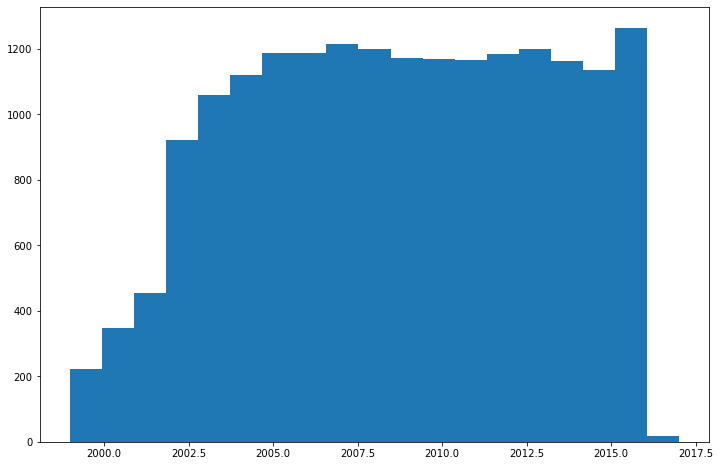

In [7]:
# Histogram of review publication dates
plt.subplots(figsize=(12,8))
plt.hist(scores.pub_year, bins=scores.pub_year.nunique())
plt.show()

### Build a minimal dataframe and remove bad data

We only want two of the columns in the data (review text and album score, and we know that there are some empty fields than can cause downstream problems. Merge the two existing dataframes, eliminate duplicateentries, null values, and any review that is less than 1,000 characters (not words!) long.

In [8]:
# Merge and clean data
data = scores[['reviewid', 'score']].merge(reviews[['reviewid', 'content']]).drop_duplicates().set_index(['reviewid'])
data = data.loc[data.content.str.len()>1000]
data.head()

,score,content
reviewid,,
22703,9.3,"“Trip-hop” eventually became a ’90s punchline,..."
22721,7.9,"Eight years, five albums, and two EPs in, the ..."
22659,7.3,Minneapolis’ Uranium Club seem to revel in bei...
22661,9.0,Kleenex began with a crash. It transpired one ...
22725,8.1,It is impossible to consider a given release b...


In [9]:
# Describe the resulting dataframe
data.describe()

,score
count,18362.00000
mean,7.00684
std,1.29226
min,0.00000
25%,6.40000
50%,7.20000
75%,7.80000
max,10.00000


## 1. Create gold labels (10 points)

* Using the `score` column of your `data` frame, create a vector `y_binary` of gold labels for your album scores. `y_binary` should be a 1D array (or list, or pandas series) of length `len(data)` that contains a 1 for each album that scored above the mean score in the dataset and a 0 for each below-average album. **Print the length of your `y_binary` vector.** (8 points)
* Calculate the fraction of all albums in the dataset that scored above the mean and **print your result**. (2 points)
    * This is your naïve baseline accuracy. Any useful classifier must achieve an accuracy score higher than this value.

## 2. Build a token-based classifier (20 points)

* Use a `TfidfVectorizer` with reasonable parameters to vectorize the review texts, then **print the shape of the resulting feature matrix**. (5 points)
    * Note that you can pass a pandas column of text data directly to `TfidfVectorizer` without further modification. 
* Standard-scale your features to mean 0 and variance 1. (5 points)
* Select the 300 most informative features using the `mutual_info_classif` criterion. This step is a bit slow (5-10 minutes on my laptop). (5 points)
* Calculate a 10-fold cross-validated accuracy score using a logistic regression classifier on your selected feature data. **Print the resulting (mean) score.** (5 points)

## 3. Build a word-embedding-based classifier (30 points)

* Write a function, `get_doc_embedding`, that takes as arguments a text string and a spaCy NLP factory object and returns a word embedding vector that is the average of the vectors of the non-stop tokens in the input text. (10 points)
    * Your function should remove any token that spaCy tags as `is_stop`, `is_punct`, or `is_space`, as well as any token that does not have an embedding vector (`has_vector` is false).
    * Verify that your function performs as expected. Given the input string `"The bad cat is drinking my coffee."` your function should return a vector of length 300 that begins:
    
    ```
    array([-2.64290750e-01,  4.09179926e-02, -1.56642497e-01, -3.10544997e-01,
             -2.02784732e-01,  2.10001752e-01, -1.87555015e-01, -1.89046592e-01, 
             ...
    ```
    
    This vector is the mean of the embeddings for the tokens `[bad, cat, drinking, coffee]`.
* Pass the text of each review to your `get_doc_embedding` function and store the output as a row in a numpy array of shape `len(data)` x `nlp.vocab.vectors_length`. This is your feature matrix. Calculating it may be slow (30 minutes on my laptop using a non-optimized approach). You may want to do your development on a small subset of the data). **Print the shape of the resulting matrix.** (10 points)
* Standard scale your embedding feature matrix and compute a 10-fold cross-validated logistic regression classification score. Print this score. (10 points)
    * If you encounter a `ConvergenceWarning` during cross validation, increase `max_iters` in your classifier. 

## 4. Evaluate regression performance (10 points)

* Using the scaled token- and embedding-based feature matrices you calculated above, compare the 10-fold cross-validated $R^2$ score for a linear (not logistic) regressor using each of those two input types. Print the score for each case. (5 points each)

## 5. Improve classification performance and comment on your results (30 points)

* Experiment with both the token-based and the embedding-based classification tasks in order to improve classification accuracy. Anything is fair game. **Show your work and clearly display the cross-validated score of your best-performing classifer for each feature type.** (10 points for improved accuracy)
* Comment on your experimental process and results. What did you try? What improved accuracy? What didn't? By how much were you able to improve? Why do you think your best approach out-performed the others? (20 points)

Note that iterating on the full dataset may be slow. It's fine to do your development work on a subset of the data, but be sure to present your best cross-validated scores as run on the full dataset. It's possible, of course, that a classifier that performs well on a random subset of the full data may not perform as well on the full dataset. 